In [ ]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import math 
import random
from tqdm import tqdm
import sys
import os
#from torchvision.datasets import FASHION MNIST
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

##To get different random model weights

In [ ]:
#https://wandb.ai/sauravmaheshkar/RSNA-MICCAI/reports/How-to-Set-Random-Seeds-in-PyTorch-and-Tensorflow--VmlldzoxMDA2MDQy
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")


In [ ]:
set_seed()

Random seed set as 42


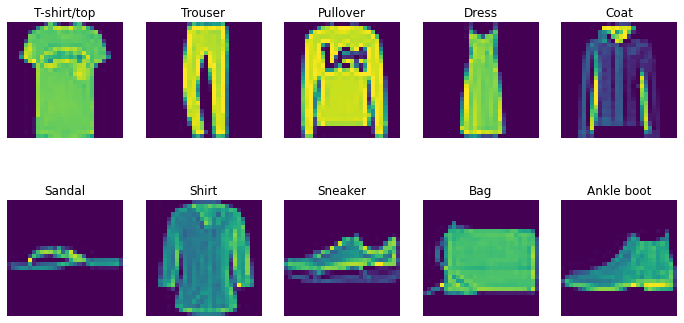

In [ ]:
# Define the class labels to print original images for
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Define transformation to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

# Load test dataset
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                        download=True, transform=transform)

# Print original images for each class
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    class_indices = np.where(np.array(testset.targets) == i)[0]
    img = testset.data[class_indices[0]].numpy()
    ax.imshow(img)
    ax.set_title(classes[i])
    ax.axis('off')
plt.show()


#Question 3A: Classification image for each digit by white noise equation. First define a function for all the noise images.Then do a loop over for all the images to average them.

Number of images for class T-shirt/top: 500
Number of images for class Trouser: 500
Number of images for class Pullover: 500
Number of images for class Dress: 500
Number of images for class Coat: 500
Number of images for class Sandal: 500
Number of images for class Shirt: 500
Number of images for class Sneaker: 500
Number of images for class Bag: 500
Number of images for class Ankle boot: 500


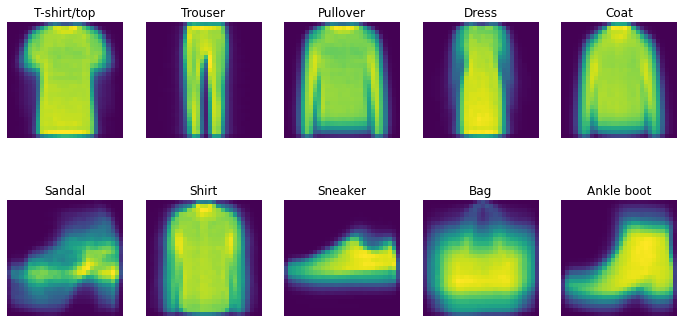

In [ ]:
# Define the gamma value
gamma = 0.2

# Define the number of samples and image shape
n_samples = 500
img_shape = (28, 28)

# Define the classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Load test dataset
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

def generate_noise_maps_per_class(cls, n_samples, gamma, img_shape=(28, 28)):
    noise_maps = []
    class_indices = np.where(np.array(testset.targets) == cls)[0]
    class_indices = class_indices[:n_samples]
    print(f"Number of images for class {classes[cls]}: {len(class_indices)}")
    for idx in class_indices:
        # Get original image
        img = testset.data[idx].numpy()
        # Generate random noise
        noise = np.random.randn(*img_shape)
        # Combine noise with original image
        noisy_img = gamma * noise + (1 - gamma) * img
        noise_maps.append(noisy_img)
    return np.array(noise_maps)

# Generate noise maps for each class and average them
noise_maps=[]
avgd_noise_maps = []
for cls in range(len(classes)):
    class_noise_maps = generate_noise_maps_per_class(cls, n_samples, gamma, img_shape=(28,28))
    avg_noise_map = np.mean(class_noise_maps, axis=0)
    avgd_noise_maps.append(avg_noise_map)
    noise_maps.append(class_noise_maps)

all_noise_maps = np.concatenate(noise_maps)

# Plot the noise maps
fig, axs = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(avgd_noise_maps[i])
    ax.set_title(classes[i])
    ax.axis('off')
plt.show()


#Train the model and test on MNIST test dataset 

In [ ]:
# Set device to CUDA if available, otherwise use CPU
#device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#These transformations below will randomly crop the images to 28x28 pixels with padding of 4 pixels, 
#randomly flip the images horizontally, and randomly rotate the images up to 10 degrees. 
#This can help the model generalize better to new data and improve its performance.
transform = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Load the training and test datasets
train_dataset = datasets.FashionMNIST('data/', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('data/', train=False, download=True, transform=transform)


# Create data loaders for the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

# Move data and model to device (CUDA or CPU)
train_loader = train_loader



# define the model architecture
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(20, 50, kernel_size=5)
        self.fc1 = torch.nn.Linear(4*4*50, 500)
        self.fc2 = torch.nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    
model = Model()


# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3) 

# define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# set the number of epochs
EPOCHS = 20

# create empty list to store the losses for each batch
losses = []

# initialize best accuracy to zero
best_accuracy = 0

# train the model
for epoch in range(EPOCHS):
    # set the model to train mode
    model.train()

    # loop over the batches in the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cpu(), target.cpu()
        # move the data to the device
        #data, target = data.to(device), target.to(device)

        # zero out the gradients
        optimizer.zero_grad()

        # forward pass
        y_pred = model(data)

        # calculate the loss
        loss = loss_fn(y_pred, target)

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()

        # save the loss for this batch
        losses.append(loss.item())

    # evaluate the model on the test set
    model.eval()

    # create empty list to store the predictions
    predictions = []

    # loop over the batches in the test set
    for data, target in test_loader:
        # move the data to the device
        data = data.cpu()
        target = target.cpu()

        # forward pass
      
        output = model(data)


        # get the predicted class
        #pred = output.argmax(dim=1, keepdim=True)
        
        pred = output.data.max(1)[1]
        d = pred.eq(target.data).cpu()
        accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

        # save the predictions
        predictions.append(pred.cpu().numpy())

    # concatenate the predictions into a single array
    predictions = np.concatenate(predictions)

    # calculate the accuracy
    test_targets = test_loader.dataset.targets.numpy()
    accuracy = np.mean(predictions == test_targets)

    # print the loss and accuracy for this epoch
    print(f"Epoch {epoch+1}/{EPOCHS}, loss: {losses[-1]:.4f}, accuracy: {accuracy:.4f}")

    # save the model if it has the best accuracy so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_model2.pt")
        print("Best model saved!")



Epoch 1/20, loss: 0.8597, accuracy: 0.7470
Best model saved!
Epoch 2/20, loss: 0.5659, accuracy: 0.7926
Best model saved!
Epoch 3/20, loss: 0.4547, accuracy: 0.8099
Best model saved!
Epoch 4/20, loss: 0.4484, accuracy: 0.8228
Best model saved!
Epoch 5/20, loss: 0.3780, accuracy: 0.8258
Best model saved!
Epoch 6/20, loss: 0.5272, accuracy: 0.8398
Best model saved!
Epoch 7/20, loss: 0.3198, accuracy: 0.8393
Epoch 8/20, loss: 0.4239, accuracy: 0.8456
Best model saved!
Epoch 9/20, loss: 0.2421, accuracy: 0.8508
Best model saved!
Epoch 10/20, loss: 0.3786, accuracy: 0.8561
Best model saved!
Epoch 11/20, loss: 0.3291, accuracy: 0.8582
Best model saved!
Epoch 12/20, loss: 0.3640, accuracy: 0.8629
Best model saved!
Epoch 13/20, loss: 0.3929, accuracy: 0.8652
Best model saved!
Epoch 14/20, loss: 0.2383, accuracy: 0.8627
Epoch 15/20, loss: 0.3647, accuracy: 0.8659
Best model saved!
Epoch 16/20, loss: 0.3682, accuracy: 0.8609
Epoch 17/20, loss: 0.1874, accuracy: 0.8653
Epoch 18/20, loss: 0.2999, 

##Second Attempt Model. Not better than original Model

In [ ]:
# Set device to CUDA if available, otherwise use CPU
#device = torch.device('cpu')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#These transformations below will randomly crop the images to 28x28 pixels with padding of 4 pixels, 
#randomly flip the images horizontally, and randomly rotate the images up to 10 degrees. 
#This can help the model generalize better to new data and improve its performance.
transform = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Load the training and test datasets
train_dataset = datasets.FashionMNIST('data/', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST('data/', train=False, download=True, transform=transform)


# Create data loaders for the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256, shuffle=False)

# Move data and model to device (CUDA or CPU)
train_loader = train_loader


#Adding droput layer to improve accuracy
# define the model architecture
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 20, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(20, 50, kernel_size=5)
        self.fc1 = torch.nn.Linear(4*4*50, 500)
        self.dropout = torch.nn.Dropout(p=0.5)  # add dropout layer
        self.fc2 = torch.nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # apply dropout
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    
model = Model()


# After seeing low accuracy of Model testing with noisy Fashion-MNIST images (Accuracy: 0.5437926878264363), I decided to add weight_decay. 
# Weight decay: Weight decay is a regularization technique that adds a penalty term to the loss 
# function to encourage the model to use smaller weights. 
# This can help prevent overfitting and improve generalization. 

# Learning rate scheduling: decrease the learning rate of the optimizer during training to help the model converge to a better solution.


# define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5) 
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
# define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

# set the number of epochs
EPOCHS = 20

# create empty list to store the losses for each batch
losses = []

# initialize best accuracy to zero
best_accuracy = 0

# train the model
for epoch in range(EPOCHS):
    # set the model to train mode
    model.train()

    # loop over the batches in the training set
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cpu(), target.cpu()
        # move the data to the device
        #data, target = data.to(device), target.to(device)

        # zero out the gradients
        optimizer.zero_grad()

        # forward pass
        y_pred = model(data)

        # calculate the loss
        loss = loss_fn(y_pred, target)

        # backward pass
        loss.backward()

        # update the weights
        optimizer.step()

        # save the loss for this batch
        losses.append(loss.item())

    # evaluate the model on the test set
    model.eval()

    # create empty list to store the predictions
    predictions = []

    # loop over the batches in the test set
    for data, target in test_loader:
        # move the data to the device
        data = data.cpu()
        target = target.cpu()

        # forward pass
        #output = model([:,None,...])[0]
        #output = model(data.unsqueeze(1))[0]
        output = model(data)


        # get the predicted class
        #pred = output.argmax(dim=1, keepdim=True)
        
        pred = output.data.max(1)[1]
        d = pred.eq(target.data).cpu()
        accuracy = d.sum().type(dtype=torch.float64)/d.size()[0]

        # save the predictions
        predictions.append(pred.cpu().numpy())

    # concatenate the predictions into a single array
    predictions = np.concatenate(predictions)

    # calculate the accuracy
    test_targets = test_loader.dataset.targets.numpy()
    accuracy = np.mean(predictions == test_targets)

    # print the loss and accuracy for this epoch
    print(f"Epoch {epoch+1}/{EPOCHS}, loss: {losses[-1]:.4f}, accuracy: {accuracy:.4f}")

    # save the model if it has the best accuracy so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "best_model2.pt")
        print("Best model saved!")



Epoch 1/20, loss: 0.5469, accuracy: 0.7427
Best model saved!
Epoch 2/20, loss: 0.7473, accuracy: 0.7743
Best model saved!
Epoch 3/20, loss: 0.5310, accuracy: 0.8015
Best model saved!
Epoch 4/20, loss: 0.4753, accuracy: 0.8119
Best model saved!
Epoch 5/20, loss: 0.4236, accuracy: 0.8251
Best model saved!
Epoch 6/20, loss: 0.5103, accuracy: 0.8329
Best model saved!
Epoch 7/20, loss: 0.4694, accuracy: 0.8268
Epoch 8/20, loss: 0.4029, accuracy: 0.8506
Best model saved!
Epoch 9/20, loss: 0.6088, accuracy: 0.8497
Epoch 10/20, loss: 0.4030, accuracy: 0.8518
Best model saved!
Epoch 11/20, loss: 0.5047, accuracy: 0.8553
Best model saved!
Epoch 12/20, loss: 0.3337, accuracy: 0.8530
Epoch 13/20, loss: 0.2934, accuracy: 0.8648
Best model saved!
Epoch 14/20, loss: 0.3130, accuracy: 0.8591
Epoch 15/20, loss: 0.4386, accuracy: 0.8624
Epoch 16/20, loss: 0.2667, accuracy: 0.8639
Epoch 17/20, loss: 0.2854, accuracy: 0.8692
Best model saved!
Epoch 18/20, loss: 0.3783, accuracy: 0.8684
Epoch 19/20, loss: 

#3B Feed the average noise map back in to the CNN and report which class they are classified as

With class names

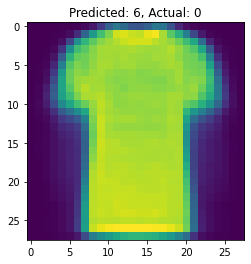

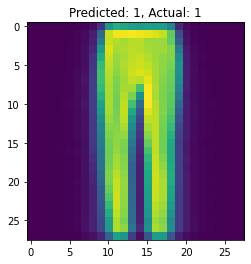

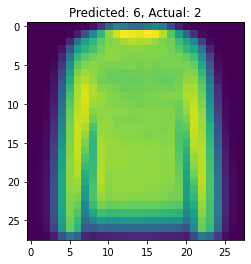

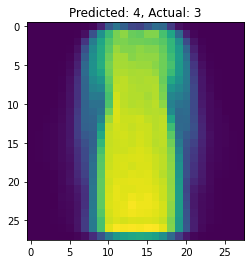

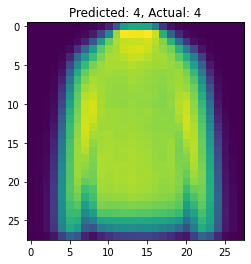

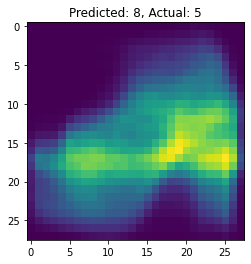

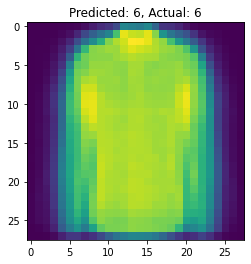

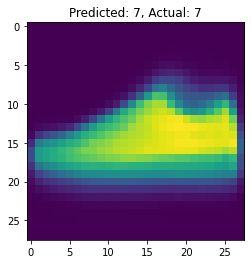

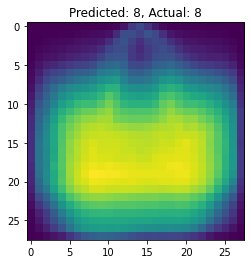

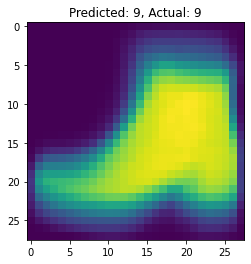

In [ ]:
# predict on averaged image
# Define the number of samples and image shape
n_samples = 500
img_shape = (28, 28)

# Define the digits to generate noise maps for
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Define the threshold for predictions
threshold = 0.7

for digit in digits:
    test_tensor = torch.from_numpy((avgd_noise_maps[digit])[None,...]).type(torch.FloatTensor)
    output = model(test_tensor)
    
    # Get the predicted class and corresponding probability
    probs = torch.softmax(output, dim=1)
    max_prob, pred_class = torch.max(probs, dim=1)
    
    # Filter out predictions with low confidence
    if max_prob >= threshold:
        # Convert the noise map to an image
        noise_map =avgd_noise_maps[digit]
        img = (noise_map * 255)
    
        # Display the image with the predicted and actual class labels
        predicted_class_name = classes[pred_class.item()]
        true_class_name = classes[digit]
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class_name}, Actual: {true_class_name}")
        plt.show()


With the number assignment of the classes

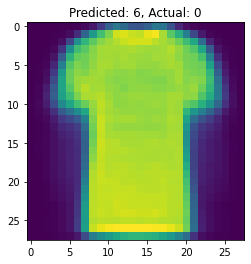

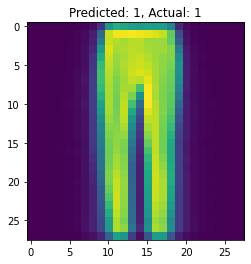

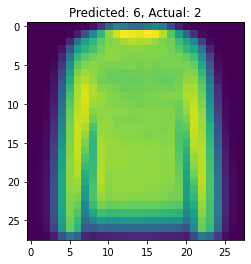

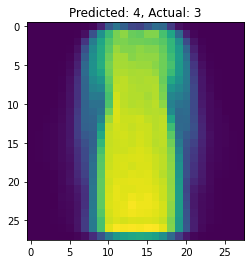

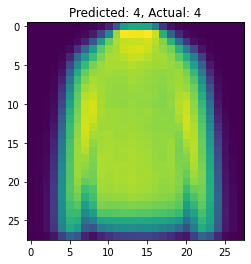

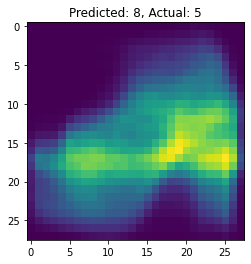

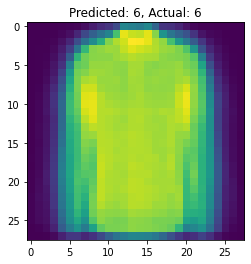

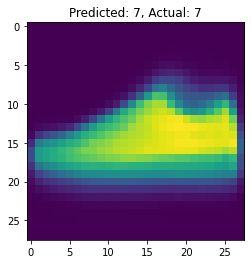

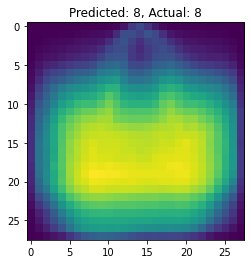

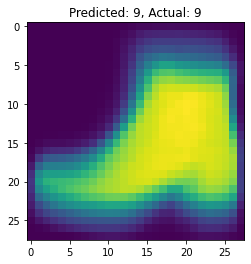

In [ ]:
# predict on averaged image
# Define the number of samples and image shape
n_samples = 500
img_shape = (28, 28)

# Define the digits to generate noise maps for
digits = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Define the threshold for predictions
threshold = 0.7

for digit in digits:
    test_tensor = torch.from_numpy((avgd_noise_maps[digit])[None,...]).type(torch.FloatTensor)
    output = model(test_tensor)
    
    # Get the predicted class and corresponding probability
    probs = torch.softmax(output, dim=1)
    max_prob, pred_class = torch.max(probs, dim=1)
    
    # Filter out predictions with low confidence
    if max_prob >= threshold:
        # Convert the noise map to an image
        noise_map =avgd_noise_maps[digit]
        img = (noise_map * 255)
    
        # Display the image with the predicted and actual class labels
        plt.imshow(img)
        plt.title(f"Predicted: {pred_class.item()}, Actual: {digit}")
        plt.show()

#3C Using all the noise maps as a classifier and report the accuracy scores across all classes with confusion matrices. 

Accuracy: 0.6097512038523274


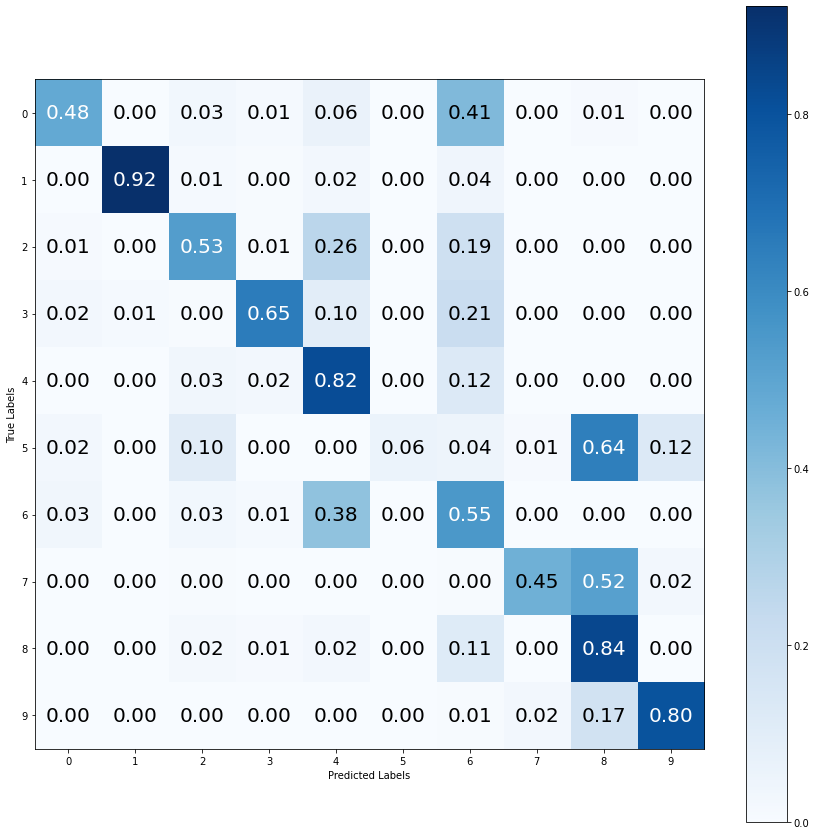

In [ ]:
# Define the threshold for predictions
threshold = 0.7

# Set the model to evaluation mode
model.eval()

# Get the true labels and predicted labels for the noise maps
true_labels = []
predicted_labels = []

with torch.no_grad():
    for i in range(all_noise_maps.shape[0]):
        test_tensor = torch.from_numpy(all_noise_maps[i][None,...]).type(torch.FloatTensor)
        outputs = model(test_tensor)
        prob = torch.softmax(outputs, dim=1)
        max_prob, predicted_label = torch.max(prob.data, 1)
        if max_prob > threshold:
            true_label = i // n_samples  # Get the true label from the digit index
            true_labels.append(true_label)
            predicted_labels.append(predicted_label.item())

# Calculate the accuracy score
accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy:', accuracy)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Set figure size
plt.figure(figsize=(15, 15))

# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.colorbar()

# Add labels to the plot
classes = [str(i) for i in range(10)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add values to the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.2f'), fontsize=20,
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# Show the plot
plt.show()


In [ ]:
# assuming you have y_true and y_pred from your model
report = classification_report(true_labels, predicted_labels)

print(report)

              precision    recall  f1-score   support

           0       0.85      0.48      0.61       497
           1       0.98      0.92      0.95       498
           2       0.70      0.53      0.60       499
           3       0.91      0.65      0.76       500
           4       0.49      0.82      0.62       500
           5       1.00      0.06      0.11       498
           6       0.32      0.55      0.41       498
           7       0.93      0.45      0.61       495
           8       0.38      0.84      0.53       499
           9       0.85      0.80      0.82       500

    accuracy                           0.61      4984
   macro avg       0.74      0.61      0.60      4984
weighted avg       0.74      0.61      0.60      4984



#Second Attempt

Accuracy: 0.44950614795404154


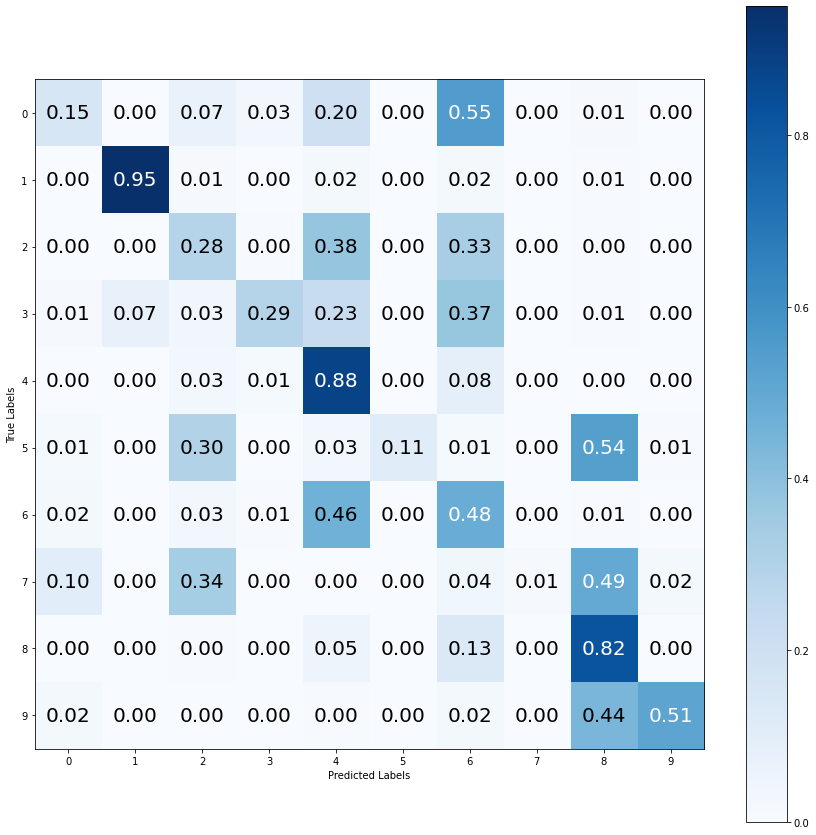

In [ ]:
# Define the threshold for predictions
threshold = 0.7

# Set the model to evaluation mode
model.eval()

# Get the true labels and predicted labels for the noise maps
true_labels = []
predicted_labels = []

with torch.no_grad():
    for i in range(all_noise_maps.shape[0]):
        test_tensor = torch.from_numpy(all_noise_maps[i][None,...]).type(torch.FloatTensor)
        outputs = model(test_tensor)
        prob = torch.softmax(outputs, dim=1)
        max_prob, predicted_label = torch.max(prob.data, 1)
        if max_prob > threshold:
            true_label = i // n_samples  # Get the true label from the digit index
            true_labels.append(true_label)
            predicted_labels.append(predicted_label.item())

# Calculate the accuracy score
accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy:', accuracy)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Set figure size
plt.figure(figsize=(15, 15))

# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.colorbar()

# Add labels to the plot
classes = [str(i) for i in range(10)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add values to the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.2f'), fontsize=20,
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# Show the plot
plt.show()


#3C  Note: Below is the confusion matrix for whole **FashionMNIST dataset** as a test data

Accuracy: 0.8969


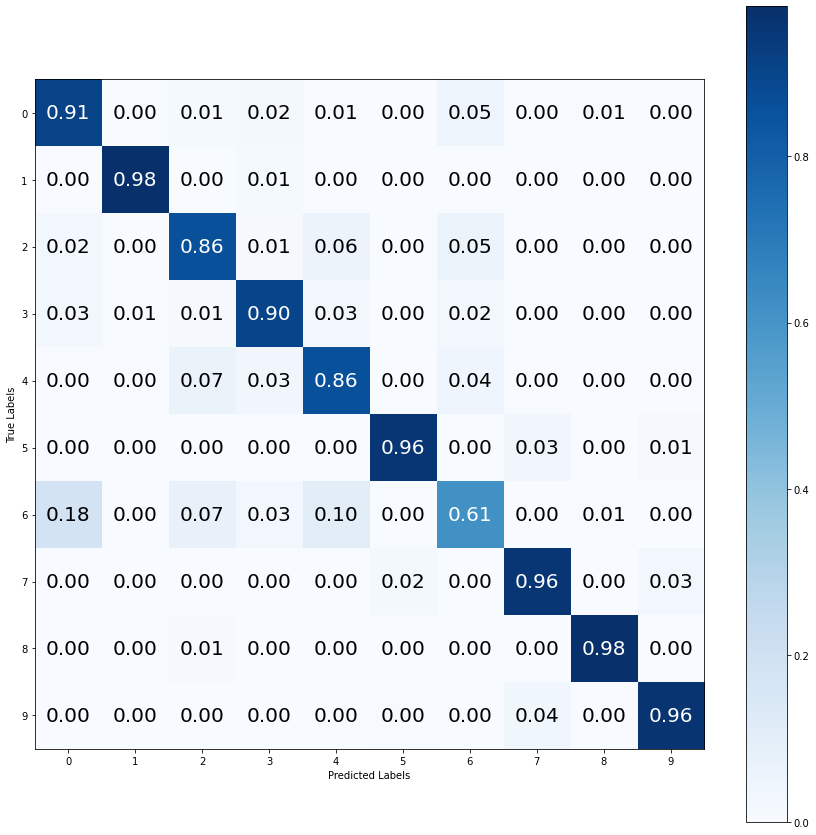

In [ ]:
# Define the transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load the test dataset
test_dataset = datasets.FashionMNIST('data/', train=False, download=True, transform=transform)

# Create data loader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Get the true labels and predicted labels for the test set
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels += labels.numpy().tolist()
        predicted_labels += predicted.numpy().tolist()

# Calculate the accuracy score
accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy:', accuracy)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Set figure size
plt.figure(figsize=(15, 15))

# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.colorbar()

# Add labels to the plot
classes = [str(i) for i in range(10)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add values to the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.2f'), fontsize=20,
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# Show the plot
plt.show()

In [ ]:
# assuming you have y_true and y_pred from your model
report = classification_report(true_labels, predicted_labels)

print(report)

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.84      0.86      0.85      1000
           3       0.90      0.90      0.90      1000
           4       0.81      0.86      0.84      1000
           5       0.98      0.96      0.97      1000
           6       0.79      0.61      0.69      1000
           7       0.93      0.96      0.94      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



#2nd attempt

In [ ]:
# Define the transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Load the test dataset
test_dataset = datasets.FashionMNIST('data/', train=False, download=True, transform=transform)

# Create data loader for the test dataset
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Set the model to evaluation mode
model.eval()

# Get the true labels and predicted labels for the test set
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels += labels.numpy().tolist()
        predicted_labels += predicted.numpy().tolist()

# Calculate the accuracy score
accuracy = accuracy_score(true_labels, predicted_labels)
print('Accuracy:', accuracy)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Set figure size
plt.figure(figsize=(15, 15))

# Plot the confusion matrix
plt.imshow(cm, cmap='Blues')
plt.colorbar()

# Add labels to the plot
classes = [str(i) for i in range(10)]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add values to the plot
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], '.2f'), fontsize=20,
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

# Show the plot
plt.show()

In [ ]:
# assuming you have y_true and y_pred from your model
report = classification_report(true_labels, predicted_labels)

print(report)